In [77]:
import data_functions as dat
import importlib
import itertools
import math
import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy as np
import os, os.path
import pandas as pd
import ri_water_model as wm
import scipy.optimize as sco
import setup_analysis as sa
import support_functions as sf
import time
from typing import *

importlib.reload(dat)
importlib.reload(wm)


<module 'ri_water_model' from '/Users/jsyme/Documents/Projects/git_jbus/dmdu_scalable_computing_2023/crdm_project/python/ri_water_model.py'>

In [79]:
%pip install pyDOE2
%pip install openpyxl
%pip 

Note: you may need to restart the kernel to use updated packages.


# Let's start by reading in some data
- get the baseline trajectories for all model inputs
- get information on climate deltas
- get annual climate deltas

In [80]:
# read in input data
df_model_data = pd.read_csv(sa.fp_csv_baseline_trajectory_model_input_data)
df_climate_deltas = pd.read_csv(sa.fp_csv_climate_deltas)
df_climate_deltas_annual = pd.read_csv(sa.fp_csv_climate_deltas_annual)

In [24]:
"""
df_attribute_primary = pd.DataFrame([tuple(x) for x in itertools.product(df_strat_full["strategy_id"].unique(), df_fut["future_id"].unique())])
df_attribute_primary.rename(columns = {0: "strategy_id", 1: "future_id"}, inplace = True)
cols = list(df_attribute_primary.columns)
df_attribute_primary["primary_id"] = range(len(df_attribute_primary))
df_attribute_primary = df_attribute_primary[["primary_id"] + cols]
df_attribute_primary.to_csv("/Users/jsyme/Documents/PRGS/Classes/2021/RDM Tutorial/tutorial2021/code/workbooks_weekly/aws_demo/experimental_design/attribute_primary_id.csv", index = None, encoding = "UTF-8")
""";


# Examine default model states, parameters, and levers

##  Set dictionary of initial states

In [6]:

wm.md_dict_initial_states


{'reservoir_storage_million_m3': 150, 'groundwater_storage_million_m3': 14000}

##  Set dictionary of parameter values

In [7]:
# default model parameters; some are calibrated, some are not (in theory)

wm.md_dict_parameters

{'area_catchment_km2': 4000,
 'costs_unmet_demand': [5, 1000, 1000],
 'groundwater_inflow_m3s': 5,
 'maximum_gw_discharge_m3s': 12.5,
 'maximum_reservoir_outflow_m3s': 25,
 'proportion_gw_discharge': 0.015,
 'proportion_precip_runoff': 0.3,
 'proportion_precip_infiltration': 0.7,
 'proportion_agricultural_water_runoff': 0.5}

##  Set lever baseline values
- lever values, as a default, are passed in a dictionary
- Keys shown in `md_dict_default_levers` can be added to the model input data frame df_in (df_model_data) to create a time series lever, and it will override the default
    - e.g., if the reservoir increases capacity, you would add a column called "capacity_reservoir_million_m3" to df_in 
    - then, you'd specify the capacity by year and month. Remember to avoid changing the default value in the model historical period


In [8]:
wm.md_dict_default_levers

{'capacity_reservoir_million_m3': 300,
 'increase_ag_efficiency_rate': 0,
 'increase_mun_efficiency_rate': 0,
 'transmission_gw_ag_m3s': nan,
 'transmission_gw_mun_m3s': 2.5,
 'transmission_res_ag_m3s': 10,
 'transmission_res_mun_m3s': 10,
 'recylcing_proportion_mun': 0.2,
 'wastewater_treatment_capacity_m3s': 0.5}

##  Apply default strategy values to two data frames
- build `df_strat_out`, which contains the defaults in a data frame
- add defaults to the model input data frame if missing

In [81]:
##  BUILD STRATEGIES AS A DATAFRAME AND EXPORT

df_strat_out = (
    df_model_data[
        [
            sa.field_time_period, 
            sa.field_year, 
            sa.field_month
        ]
    ]
    .copy()
)

for k, v in wm.md_dict_default_levers.items():
    df_strat_out[k] = v
    
df_strat_out.to_csv(
    sa.fp_csv_baseline_strategy_values,
    index = None, 
    encoding = "UTF-8"
)


##  ADD DEFAULT STRATEGY VALUES TO INPUT

for k, v in wm.md_dict_default_levers.items():
    if k not in df_model_data.columns:
        df_model_data[k] = v

In [84]:
df_model_data.tail()

,time_period,year,month,flow_m3s,precipitation_mm,population,demand_municipal_m3p,demand_agricultural_m3km2,area_ag_km2,capacity_reservoir_million_m3,increase_ag_efficiency_rate,increase_mun_efficiency_rate,transmission_gw_ag_m3s,transmission_gw_mun_m3s,transmission_res_ag_m3s,transmission_res_mun_m3s,recylcing_proportion_mun,wastewater_treatment_capacity_m3s
499,536,2055,8,11.364219,7.5,5832237,9.790576,432309.25824,150.0,300,0,0,NaN,2.5,10,10,0.2,0.5
500,537,2055,9,9.363420,0.0,5832383,9.560209,411475.07712,150.0,300,0,0,NaN,2.5,10,10,0.2,0.5
501,538,2055,10,14.124015,2.0,5832528,9.099476,411475.07712,150.0,300,0,0,NaN,2.5,10,10,0.2,0.5
502,539,2055,11,46.444056,11.8,5832674,8.869110,401057.98656,150.0,300,0,0,NaN,2.5,10,10,0.2,0.5
503,540,2055,12,49.259700,51.5,5832820,8.638743,390640.89600,150.0,300,0,0,NaN,2.5,10,10,0.2,0.5


## Run the model under default conditions
- Instantiate the object
- project under baseline

In [85]:
# instantiate the model
model = wm.RIWaterResourcesModel()

t0 = time.time()
# run the model with defaults
df_out = model.project(df_model_data)
t1 = time.time()
t1 -t0

1.1565430164337158

In [86]:
df_out.tail()

,year,month,x_11_m3,x_12_m3,x_21_m3,x_22_m3,d_1_m3,d_2_m3,d_3_m3,s_1_m3,...,r_m3,f_1_m3,f_2_m3,groundwater_storage_m3,reservoir_storage_m3,reservoir_release_m3,reservoir_spillage_m3,gw_discharge_m3,gw_recharge_m3,precip_runoff_m3
499,2055,8,1.487083e+07,6696000.0,0.000000e+00,2.509246e+07,6.428389e+07,4.758413e+07,100000000.0,1.487083e+07,...,6696000.0,281250.0,1339200.0,0.0,0.000000e+00,6696000.0,0.0,0.0,8.174833e+06,8662500.0
500,2055,9,2.812983e+07,6480000.0,0.000000e+00,1.718324e+07,6.172126e+07,4.646567e+07,100000000.0,2.812983e+07,...,6480000.0,0.0,1296000.0,0.0,0.000000e+00,6480000.0,0.0,0.0,2.164983e+07,0.0
501,2055,10,2.017100e+07,6696000.0,3.967080e+06,2.678400e+07,6.157126e+07,4.422746e+07,100000000.0,2.413808e+07,...,6696000.0,75000.0,1339200.0,0.0,0.000000e+00,6696000.0,0.0,0.0,1.347500e+07,2310000.0
502,2055,11,8.276667e+06,6480000.0,2.592000e+07,2.592000e+07,5.927370e+07,4.310886e+07,100000000.0,3.419667e+07,...,64800000.0,442500.0,1296000.0,0.0,4.055487e+06,64800000.0,0.0,0.0,1.796667e+06,13629000.0
503,2055,12,2.088967e+07,6696000.0,2.678400e+07,2.678400e+07,5.473363e+07,4.199020e+07,100000000.0,4.767367e+07,...,52117675.0,1931250.0,1339200.0,0.0,4.140604e+07,52117675.0,0.0,0.0,1.419367e+07,59482500.0


##  Option to test a pool application
- run the model 4 times asynchronusly
- NOTE: outside of Jupyter context, mp.Pool should be called within a `with` block

In [65]:
pool = mp.Pool(6)

vec_out = []
global vec_out

def get_result(result):
    global vec_out
    vec_out.append(result)
    
for id_primary in [0, 1, 2, 3]:

    # apply to pool
    pool.apply_async(
        model.project,
        args = (
            df_model_data,
        ),
        kwds = {
            "id_primary": id_primary,
        },
        callback = get_result
    )
    
pool.close()
pool.join()

# Take a look at model input variables

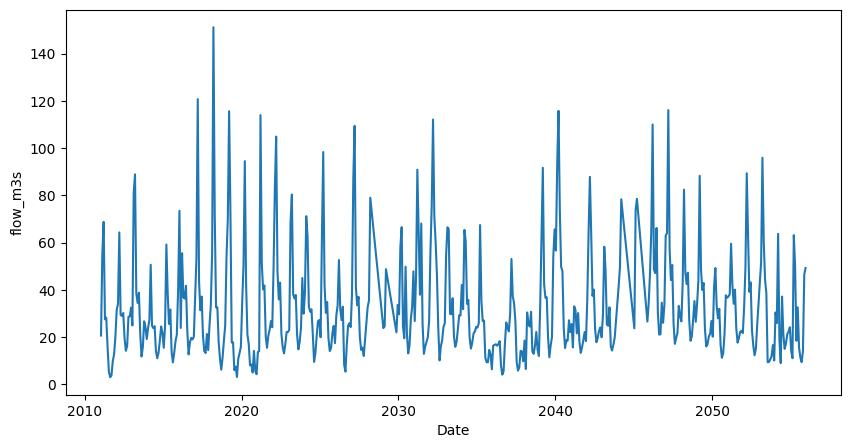

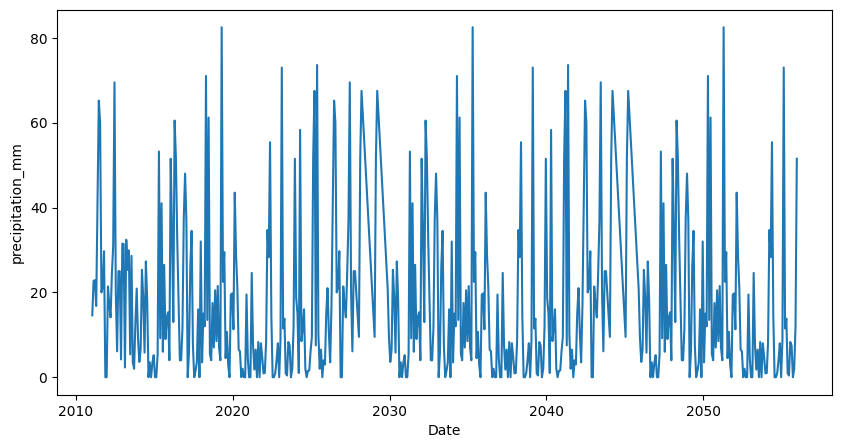

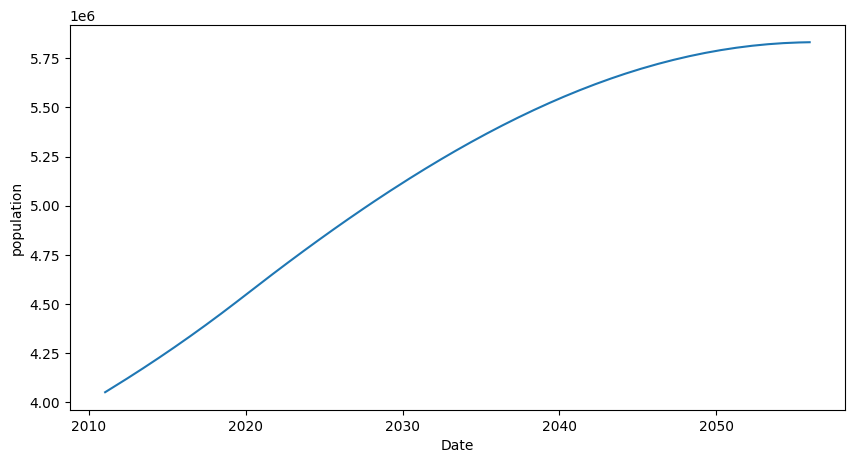

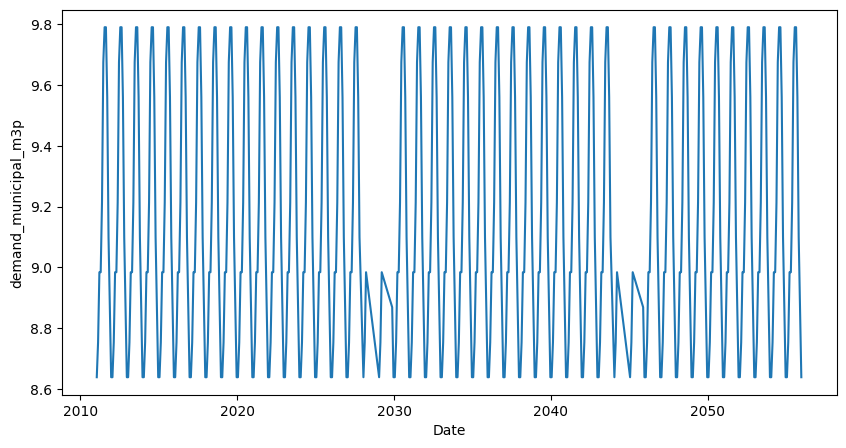

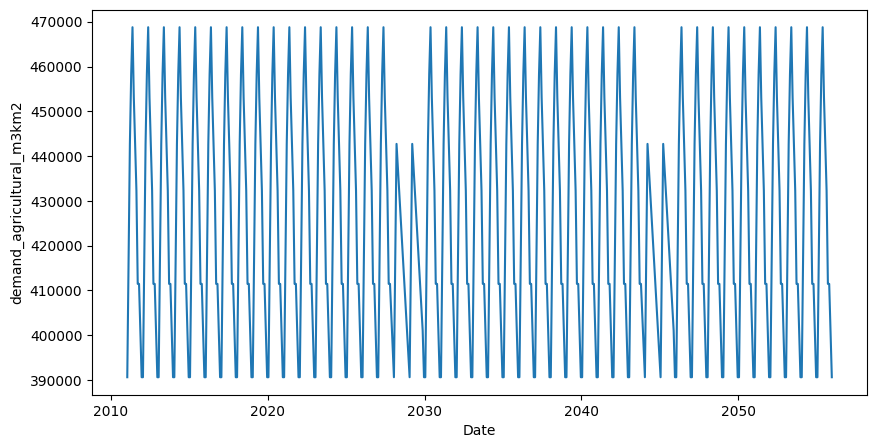

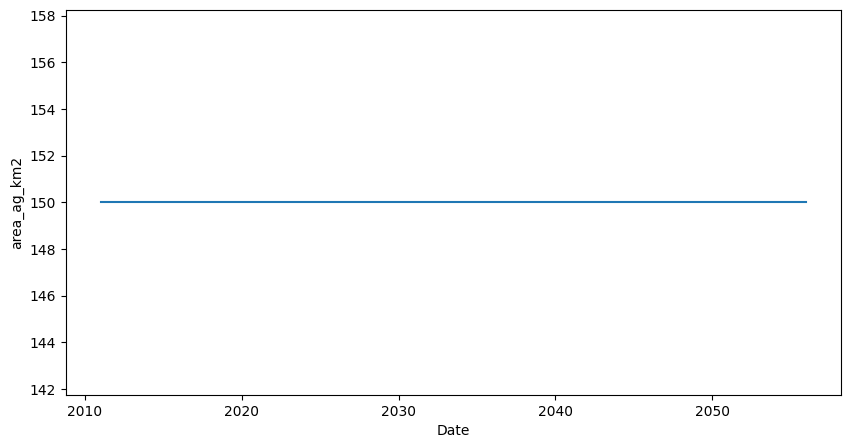

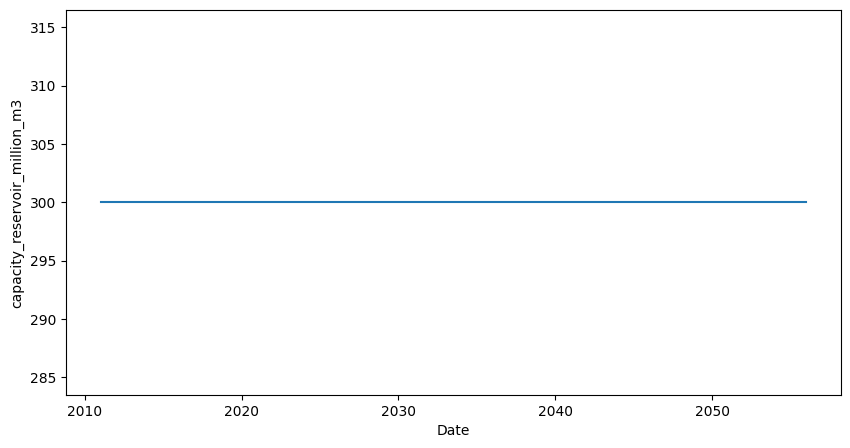

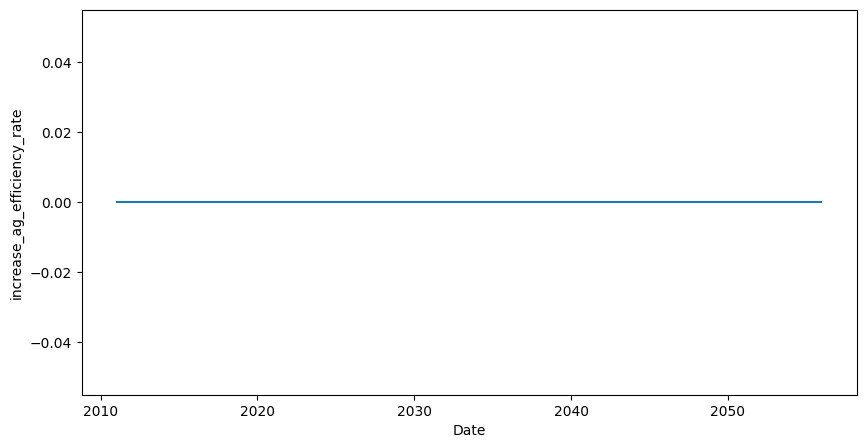

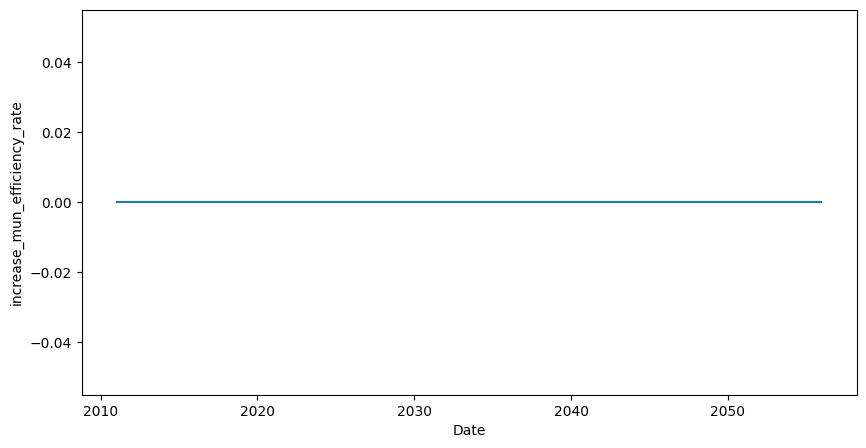

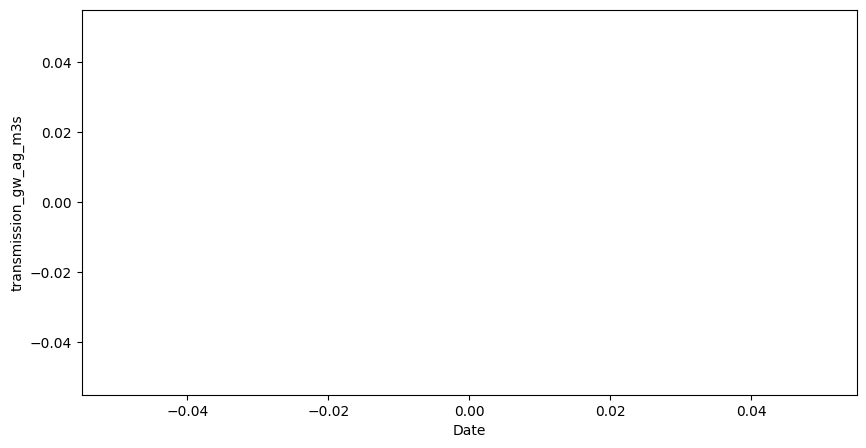

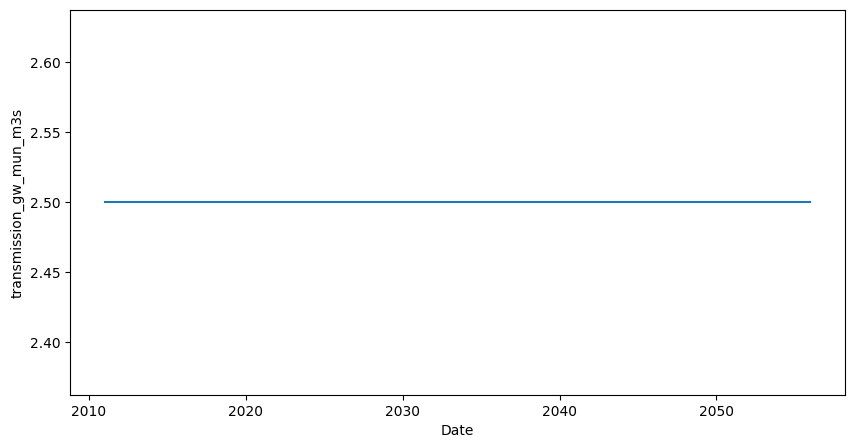

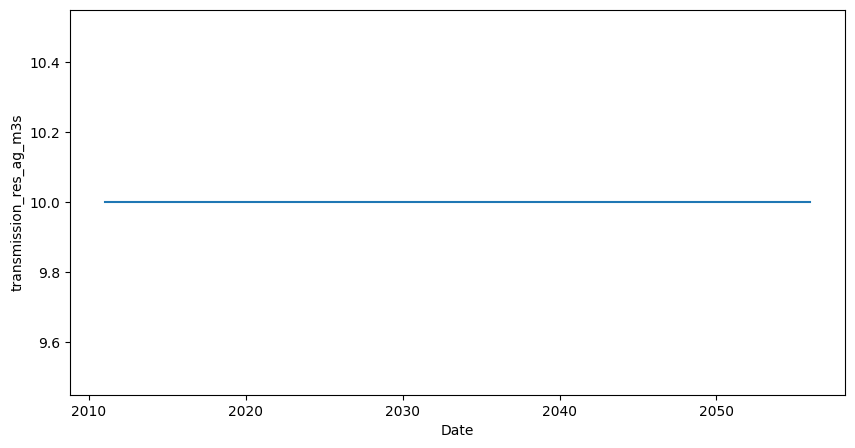

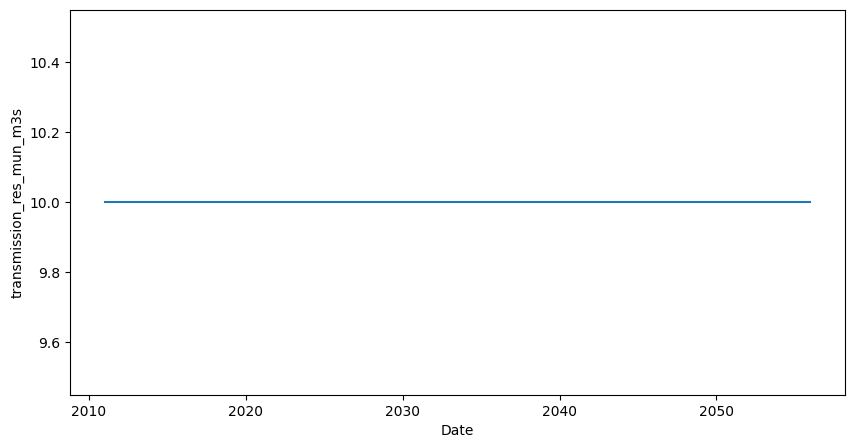

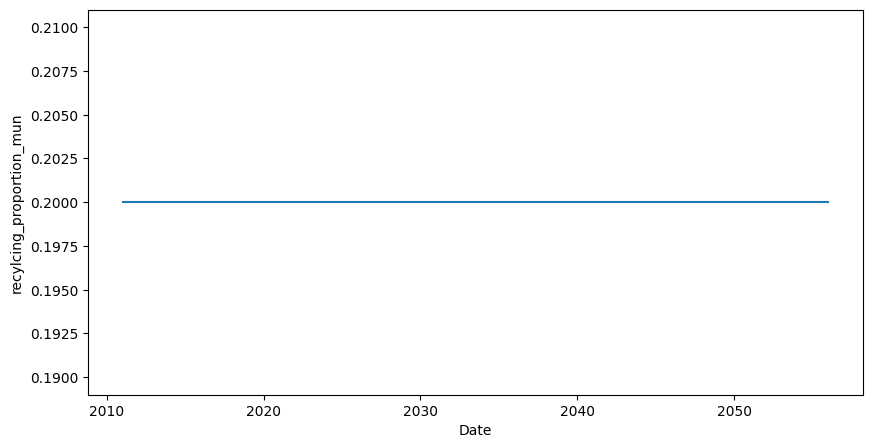

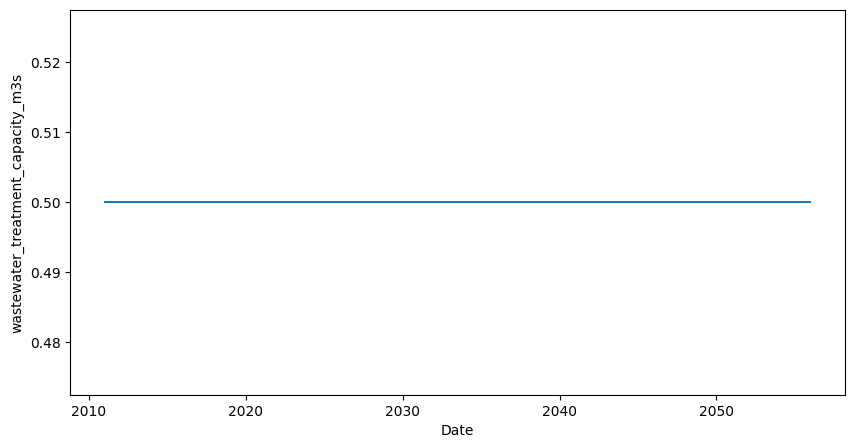

In [87]:
n = len(df_model_data)
fields_index = [
    sa.field_year,
    sa.field_month,
    sa.field_time_period
]
flds_explore = [x for x in df_model_data.columns if (x not in fields_index)]

for i in flds_explore:
    x = np.array(df_model_data[sa.field_year]) + (np.array(df_model_data[sa.field_month]) - 0.5)/12
    y = np.array(df_model_data[i].iloc[0:n])
    
    fig, ax = plt.subplots(figsize = (10, 5))
    ax.set_xlabel("Date")
    ax.set_ylabel(str(i))
    ax.plot(x, y)
    plt.show()

## Explore model output by variable

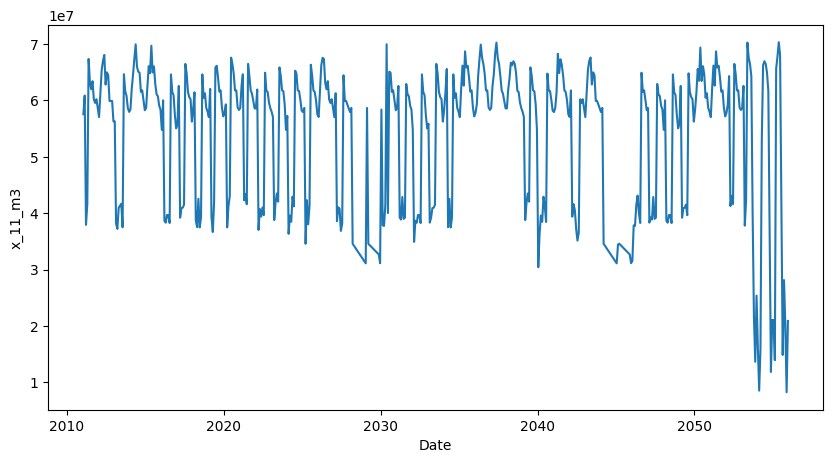

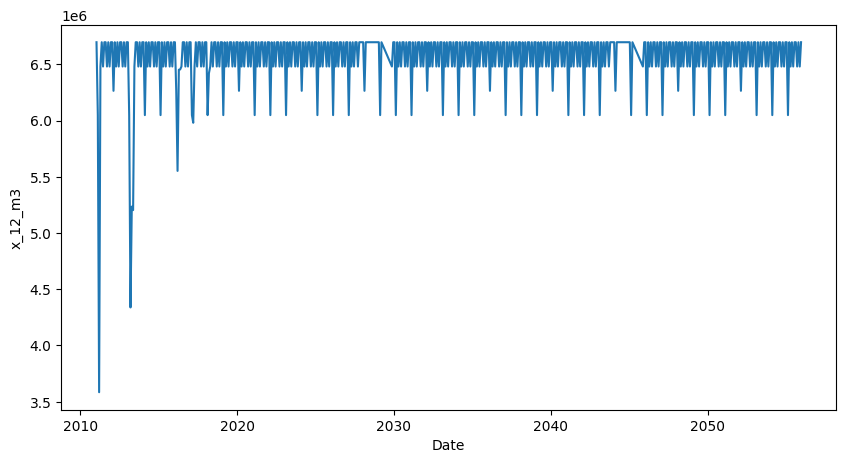

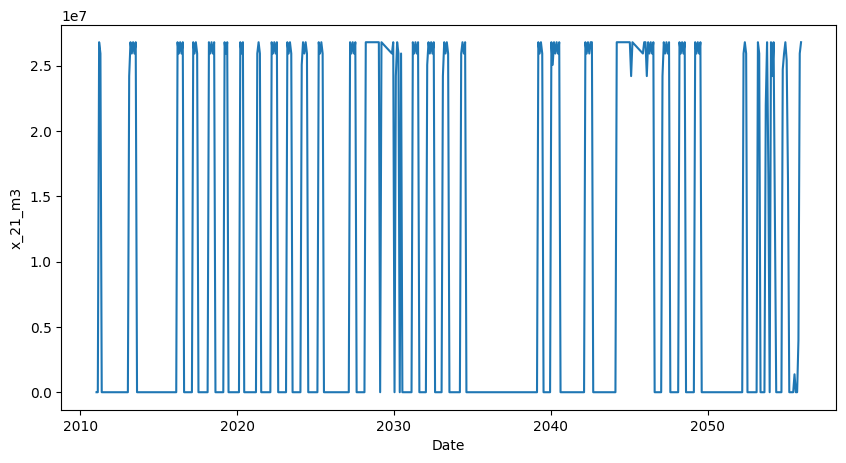

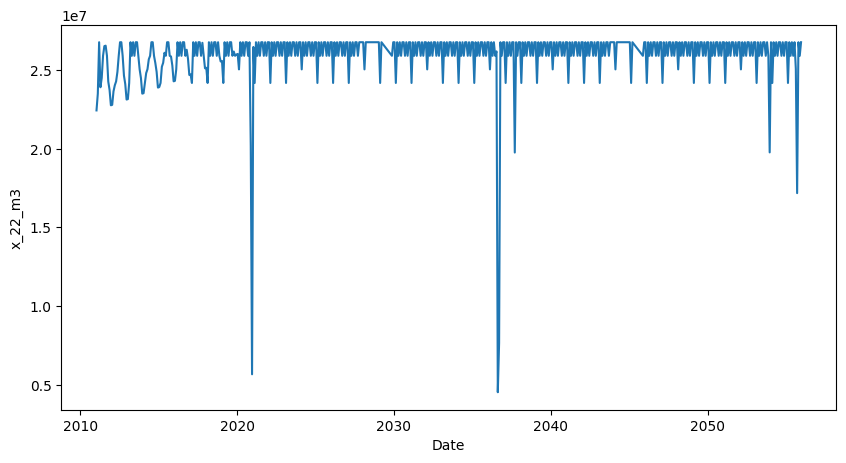

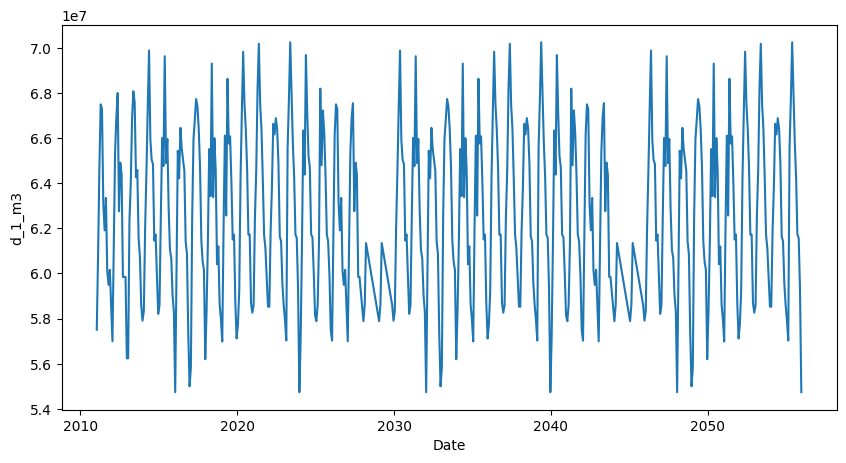

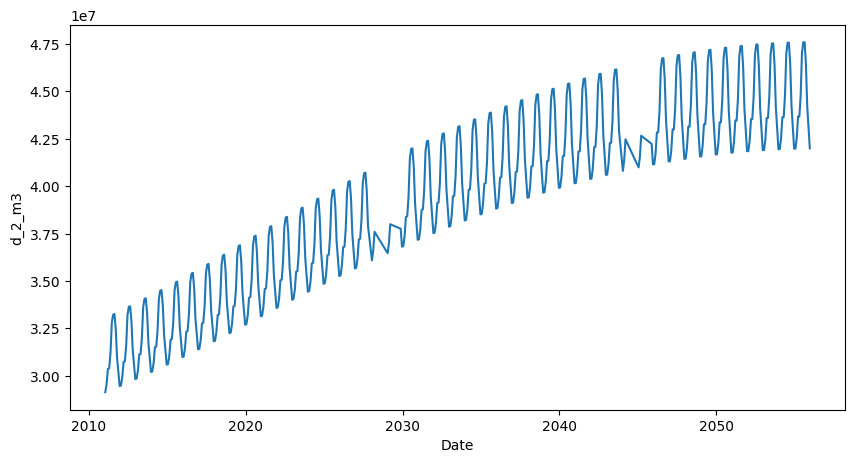

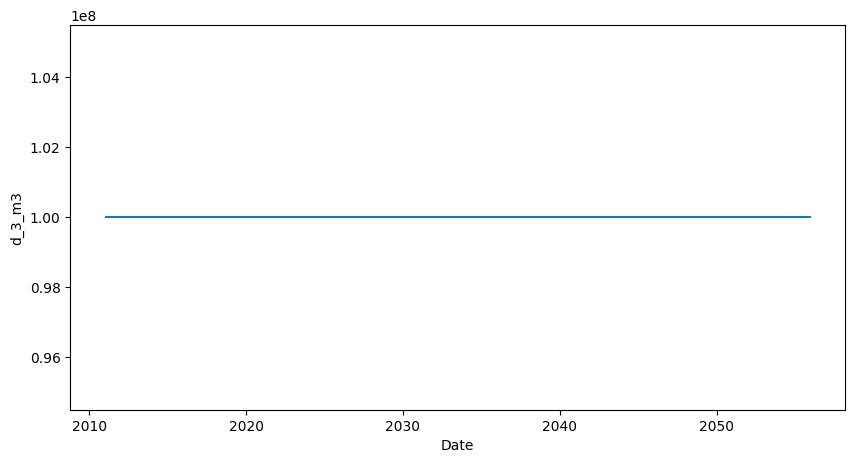

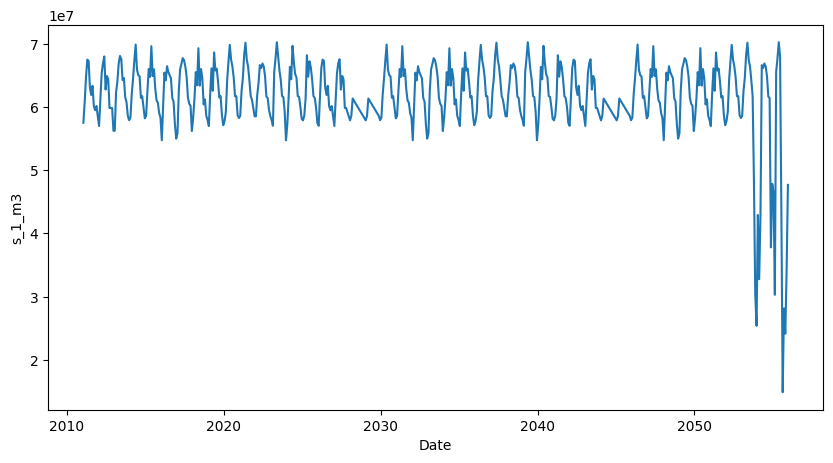

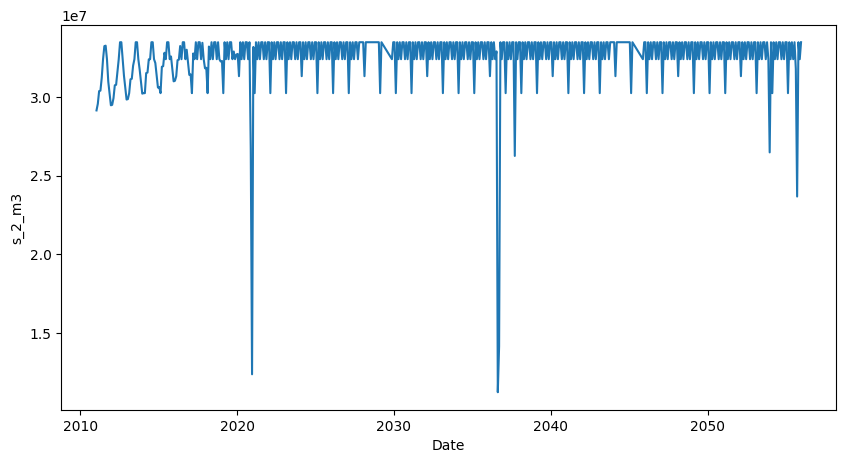

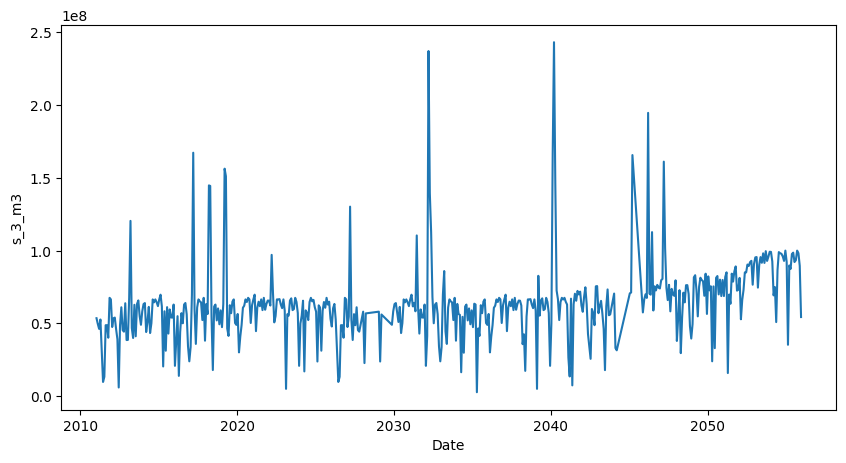

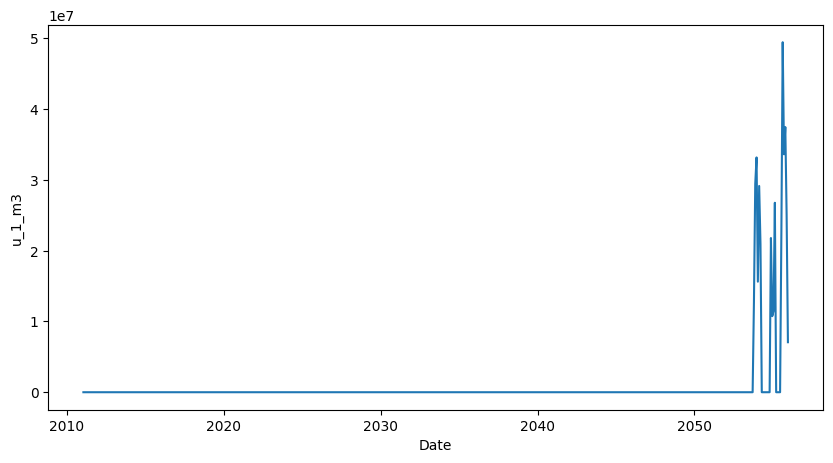

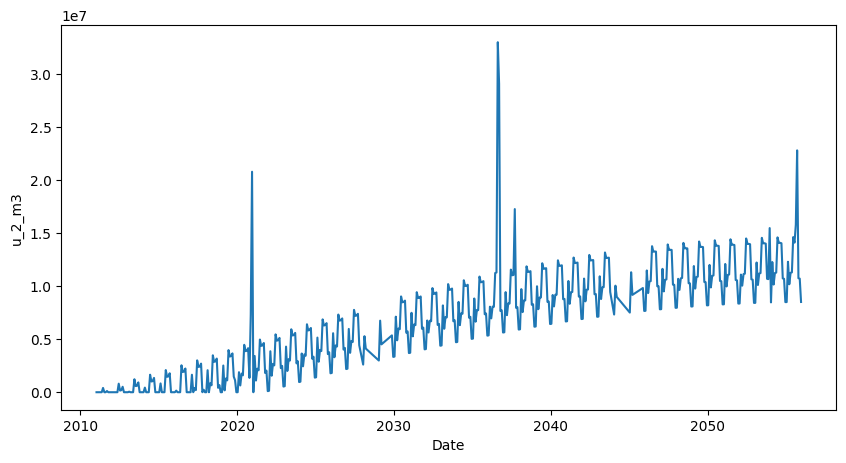

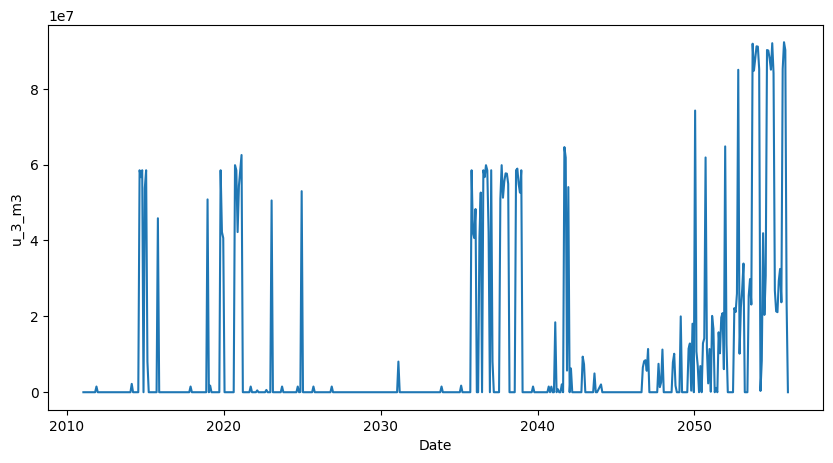

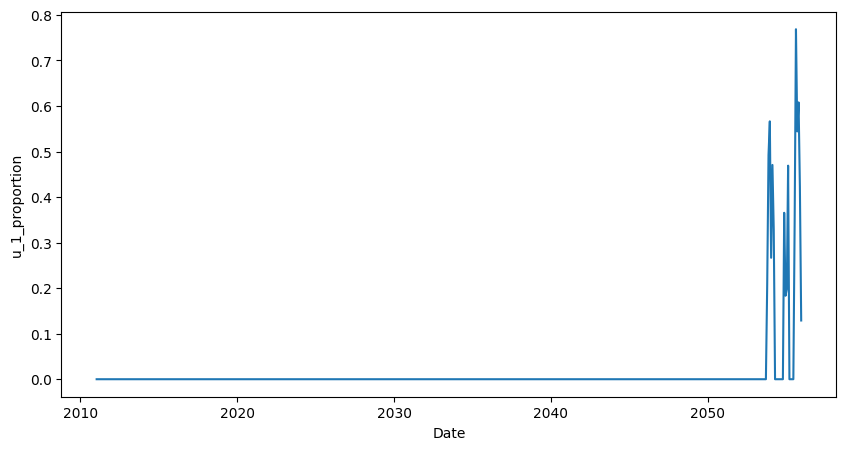

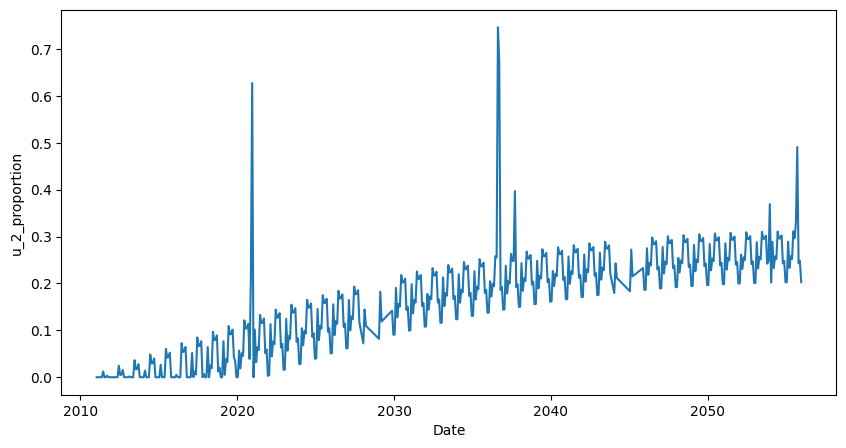

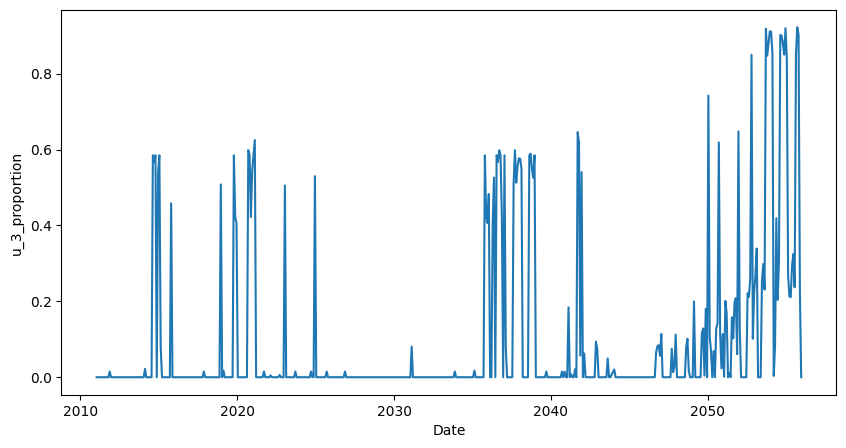

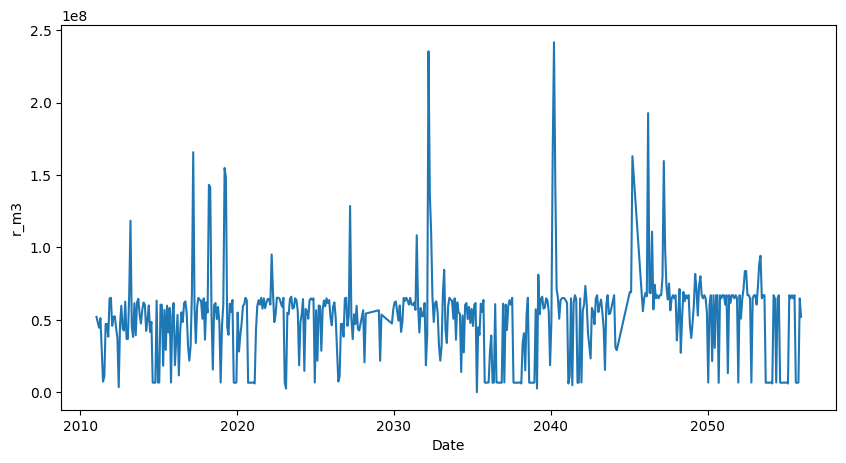

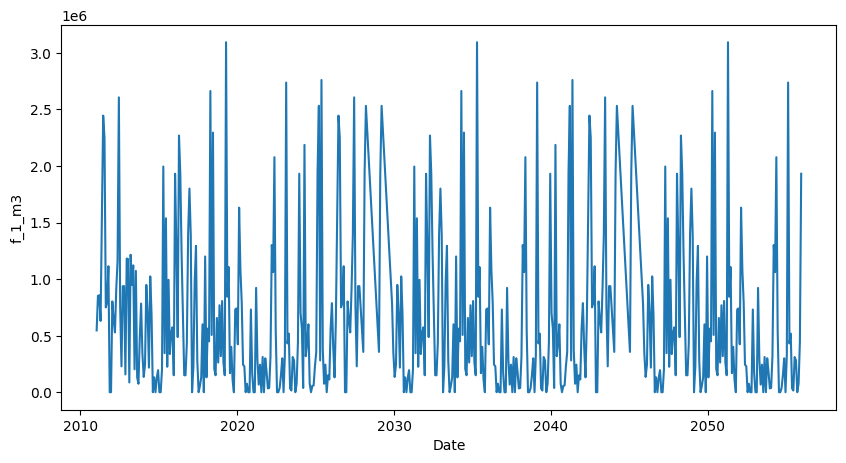

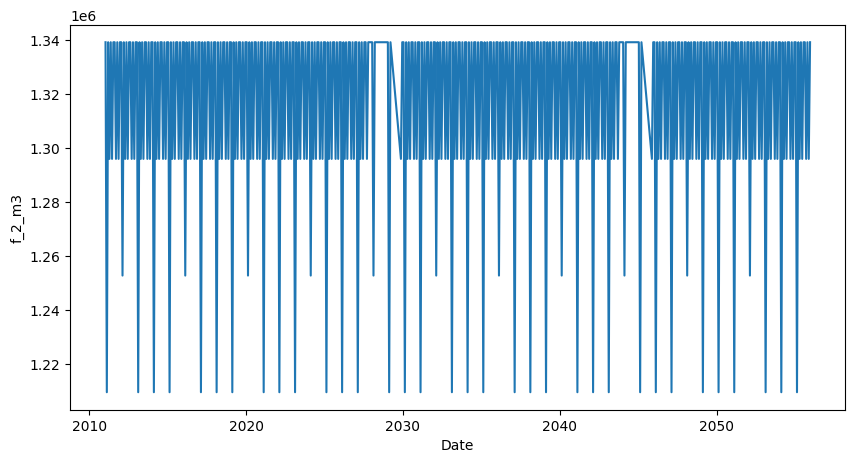

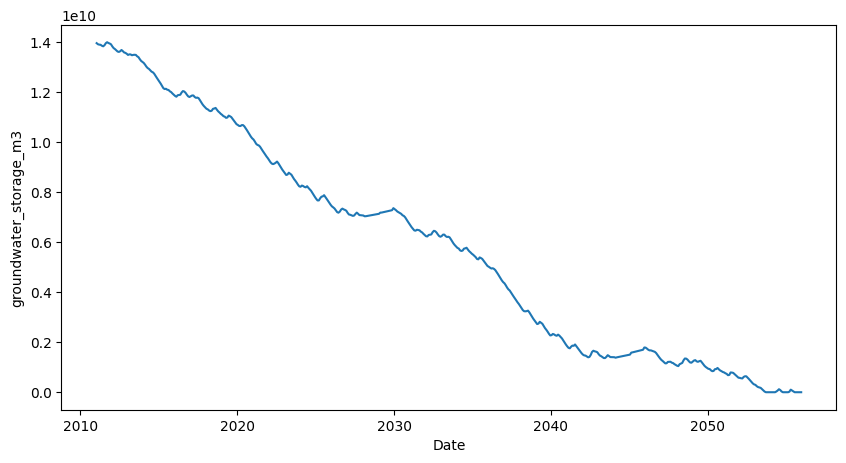

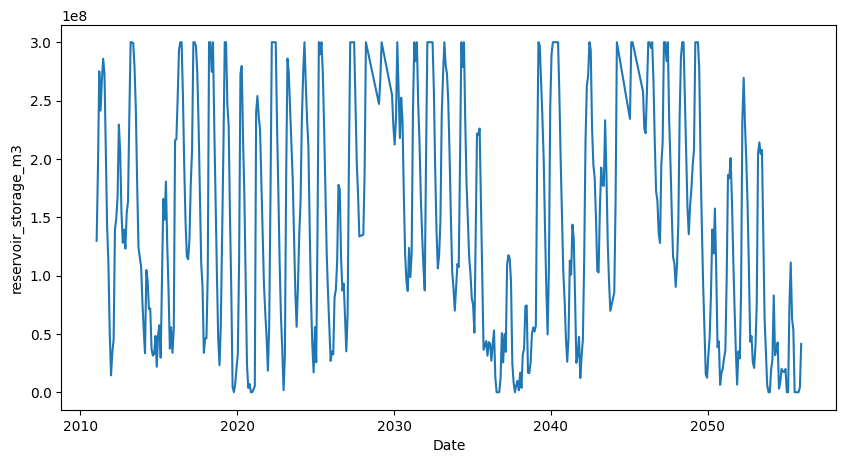

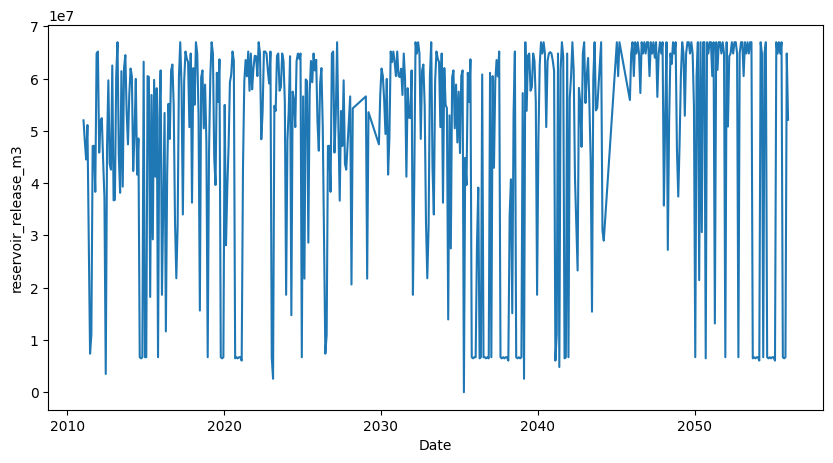

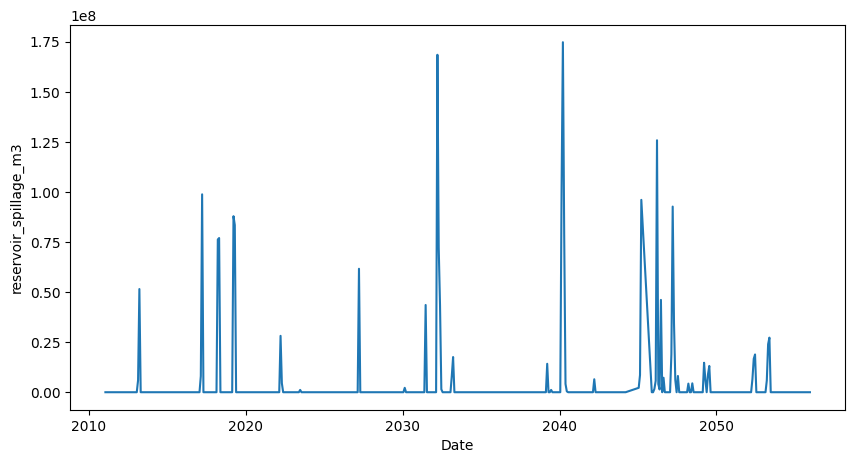

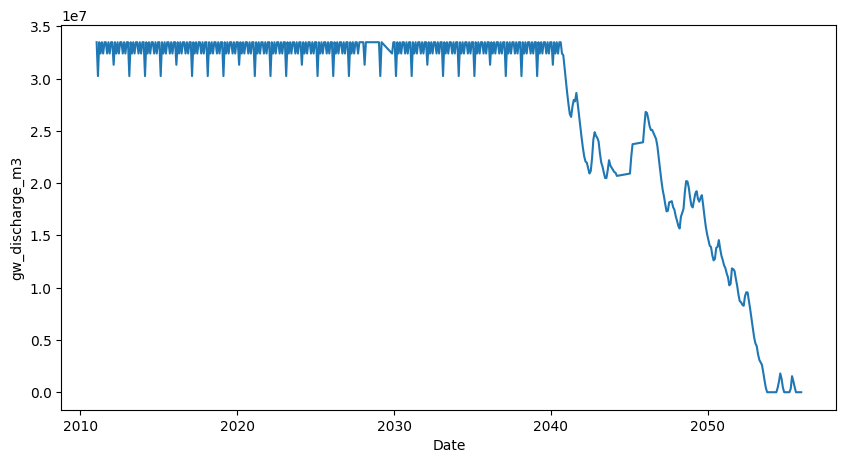

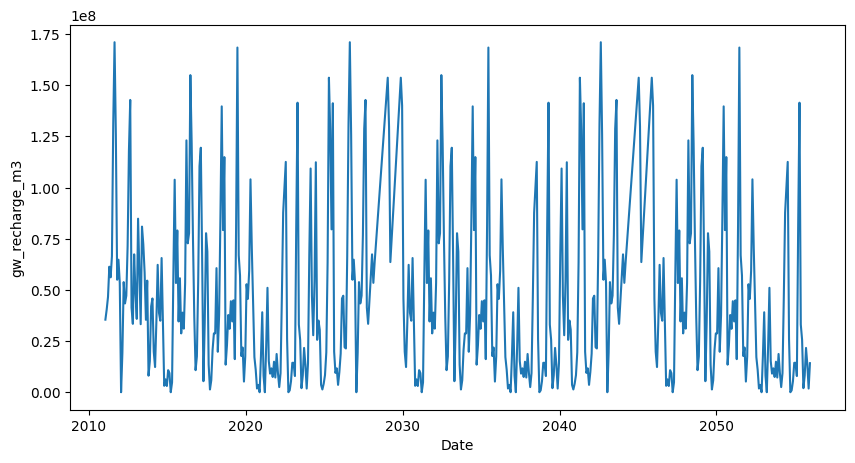

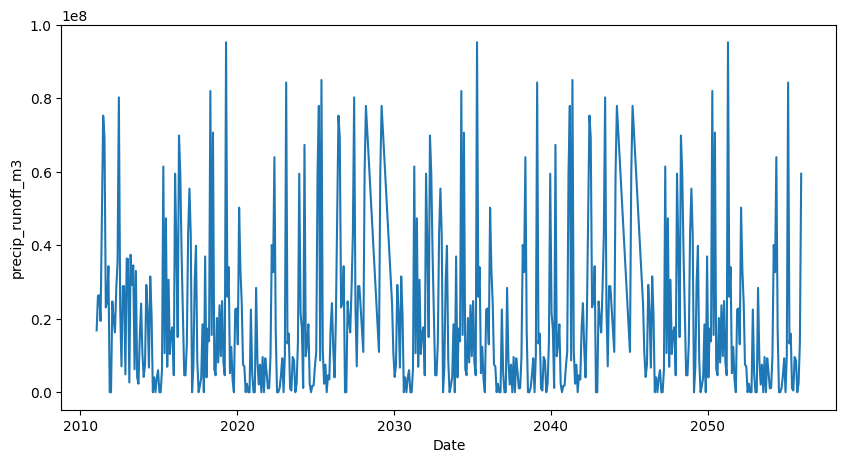

In [88]:
n = len(df_model_data)
flds_explore = [x for x in df_out.columns if (x not in ["year", "month"])]

for i in flds_explore:
    x = np.array(df_out["year"]) + (np.array(df_out["month"]) - 0.5)/12
    y = np.array(df_out[i].iloc[0:n])
    
    fig, ax = plt.subplots(figsize = (10, 5))
    ax.set_xlabel("Date")
    ax.set_ylabel(str(i))
    ax.plot(x, y)
    plt.show()
    

##  Look at some climate data

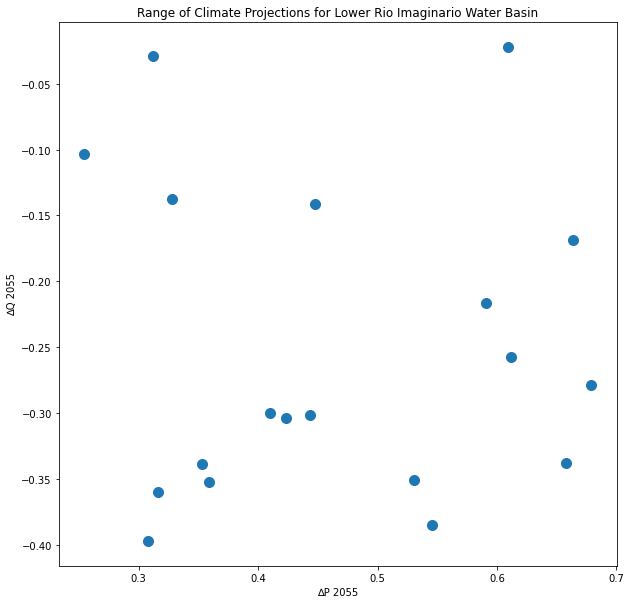

In [62]:
p = df_climate_deltas_annual["delta_p_2055_annual"]
q = df_climate_deltas_annual["delta_q_2055_annual"]
fig, ax = plt.subplots(figsize = (10, 10))
ax.set_xlabel("∆P 2055")
ax.set_ylabel("∆Q 2055")
ax.set_title("Range of Climate Projections for Lower Rio Imaginario Water Basin")
plt.scatter(p, q, s = 100)
plt.savefig("/Users/jsyme/Documents/PRGS/Classes/2021/RDM Tutorial/tutorial2021/code/crdm_project/assignment/img/climate_scatter.jpg", dpi = 300)


# After running from command line, read in here and explore how strategies perform

In [108]:
dir_out = "/Users/jsyme/Documents/Projects/git_jbus/dmdu_scalable_computing_2023/crdm_project/out/crdm_project_20230731T103453106518_100fut"

df_attribute_primary = pd.read_csv(os.path.join(dir_out, sa.fn_csv_attribute_primary_id))
df_attribute_strategy = pd.read_csv(os.path.join(dir_out, sa.fn_csv_attribute_strategy_id))
df_futures = pd.read_csv(os.path.join(dir_out, sa.fn_csv_attribute_future_id))
df_metrics = pd.read_csv(os.path.join(dir_out, sa.fn_csv_metrics))
df_output = pd.read_csv(os.path.join(dir_out, sa.fn_csv_all_output))

# some dependent functions
def get_primary_keys_from_strat(
    strat: int,
) -> List[int]:
    """
    Get list of primary keys associated with a strategy
    """
    primary_ids = list(
        df_attribute_primary[
            df_attribute_primary[sa.field_key_strategy].isin([strat])
        ][
            sa.field_key_primary
        ]
    )
    
    return primary_ids



In [147]:
df_strat_merge = (
    df_strategies[
        df_strategies['time_period'] == 540
    ][["strategy_id", "capacity_reservoir_million_m3"]]
    .copy()
    .reset_index(drop = True)
)
df_strat_merge

,strategy_id,capacity_reservoir_million_m3
0,0,300
1,1,400
2,2,400
3,3,300
4,4,400
5,5,400


In [149]:
df_prim = pd.merge(
    df_metrics,
    df_attribute_primary,
)
df_prim = pd.merge(
    df_prim, 
    df_futures,
)

df_prim = pd.merge(
    df_prim, 
    df_strat_merge,
)

df_prim

,primary_id,mean_reservoir_storage_last_ten_years_m3,mean_groundwater_storage_last_ten_years_m3,proportion_unacceptable_unmet_demand,strategy_id,future_id,area_ag_km2,demand_agricultural_m3km2,demand_municipal_m3p,flow_m3s,population,precipitation_mm,capacity_reservoir_million_m3
0,1,1.030953e+08,3.458275e+09,0.644444,0,1,1.076576,0.933383,1.041169,-0.329753,1.078674,0.346356,300
1,0,1.278909e+08,1.345088e+09,0.622222,0,0,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,300
2,3,1.521667e+08,2.423603e+09,0.644444,0,3,1.420338,1.092433,1.118841,-0.111874,0.996789,0.604272,300
3,2,1.193766e+08,8.839371e+08,0.622222,0,2,1.469141,1.060933,1.127440,-0.041955,0.873192,0.343085,300
4,6,1.471435e+08,3.449718e+09,0.644444,0,6,1.160585,0.986780,1.151407,-0.082184,0.934202,0.374978,300
...,...,...,...,...,...,...,...,...,...,...,...,...,...
601,602,2.237137e+08,7.747704e+09,0.000000,5,97,1.095155,1.018915,0.817065,-0.068063,0.979286,0.283941,400
602,601,2.428653e+08,9.584117e+09,0.000000,5,96,1.236597,1.069822,0.855348,-0.060084,1.025732,0.588096,400
603,603,2.109119e+08,1.064279e+10,0.000000,5,98,1.292738,0.971906,0.906077,-0.207047,0.836228,0.677766,400
604,605,2.186141e+08,7.404201e+09,0.200000,5,100,1.080683,1.062216,0.998175,-0.052660,0.987434,0.270145,400


In [150]:
df_prim = pd.merge(
    df_metrics,
    df_attribute_primary,
)
df_prim = pd.merge(
    df_prim, 
    df_futures,
)
df_prim = pd.merge(
    df_prim, 
    df_strat_merge,
)

df_prim.to_csv(
    "/Users/jsyme/Documents/Projects/git/ShinyAppScenarioDiscovery/ref/rio_imaginario/input_data.csv",
    index = None,
    encoding = "UTF-8",
)

##  Print some information

In [91]:
print(f"metrics:")
for k in df_metrics.columns:
    print(f"\t{k}")

print(f"strategies:")
print(df_attribute_strategy)

metrics:
	primary_id
	mean_reservoir_storage_last_ten_years_m3
	mean_groundwater_storage_last_ten_years_m3
	proportion_unacceptable_unmet_demand
strategies:
   strategy_id             strategy_name
0            0       strategy_table_base
1            1        increase_reservoir
2            2       increase_efficiency
3            3         increase_wwtp_cap
4            4           inc_res_and_eff
5            5  inc_res_and_eff_and_wwtp


# Examine the strategies

In [102]:
noise = np.random.random(5)
noise

array([0.23836792, 0.06218567, 0.6906925 , 0.31353131, 0.92569183])

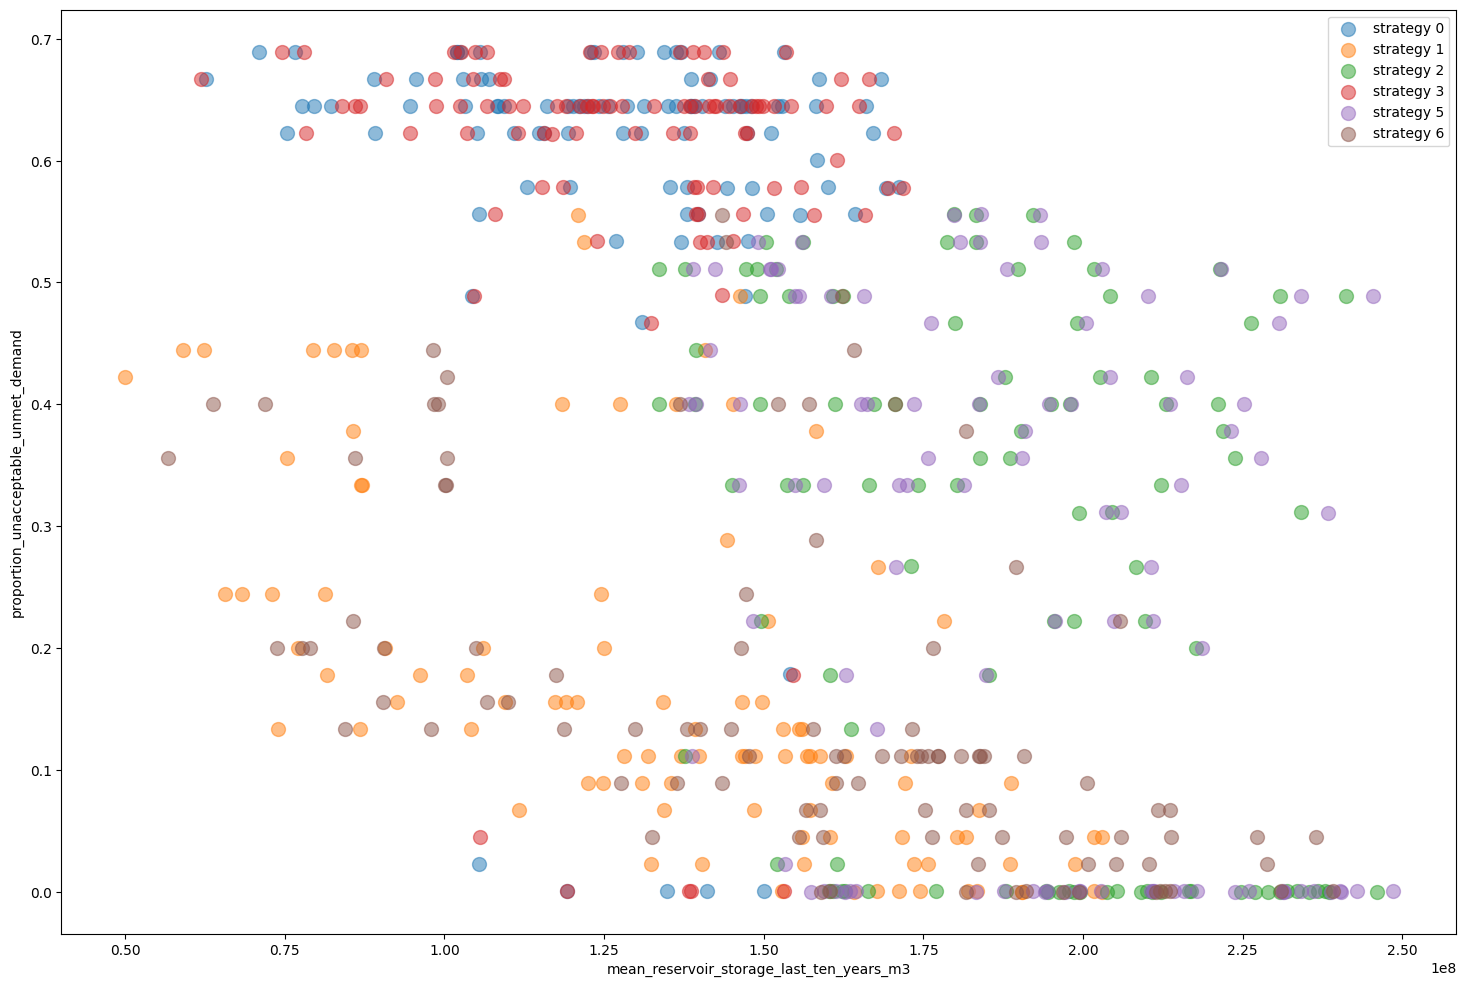

In [111]:
metric_x = "mean_reservoir_storage_last_ten_years_m3"
metric_y = "proportion_unacceptable_unmet_demand"

all_strategies = sorted(list(df_attribute_strategy[sa.field_key_strategy].unique()))


fig, ax = plt.subplots(figsize = (18, 12))

for strat in all_strategies:
    
    if strat == 4:
        continue
    primaries = get_primary_keys_from_strat(strat)
    if len(primaries) == 0:
        continue
        
    df_filt = df_metrics[
        df_metrics[sa.field_key_primary].isin(primaries)
    ]
    
    x = np.array(df_filt[metric_x]) 
    x += np.random.random(len(x))*np.mean(x)/1000 
    y = np.array(df_filt[metric_y])
    y += np.random.random(len(y))*np.mean(y)/1000
    
    ax.scatter(
        x, 
        y, 
        alpha = 0.5,
        label = f"strategy {strat}",
        s = 100, 
    )

# add some properties
ax.set_xlabel(metric_x)
ax.set_ylabel(metric_y)
ax.legend()

In [113]:
df_output.columns

Index(['year', 'month', 'x_11_m3', 'x_12_m3', 'x_21_m3', 'x_22_m3', 'd_1_m3',
       'd_2_m3', 'd_3_m3', 's_1_m3', 's_2_m3', 's_3_m3', 'u_1_m3', 'u_2_m3',
       'u_3_m3', 'u_1_proportion', 'u_2_proportion', 'u_3_proportion', 'r_m3',
       'f_1_m3', 'f_2_m3', 'groundwater_storage_m3', 'reservoir_storage_m3',
       'reservoir_release_m3', 'reservoir_spillage_m3', 'gw_discharge_m3',
       'gw_recharge_m3', 'precip_runoff_m3', 'primary_id'],
      dtype='object')

/var/folders/8m/3ll2cn6d1hdcs6gjqxr2jx5d2hffc9/T/ipykernel_40481/2211345966.py:21: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, df in dfg:


Text(0, 0.5, 'reservoir_storage_m3')

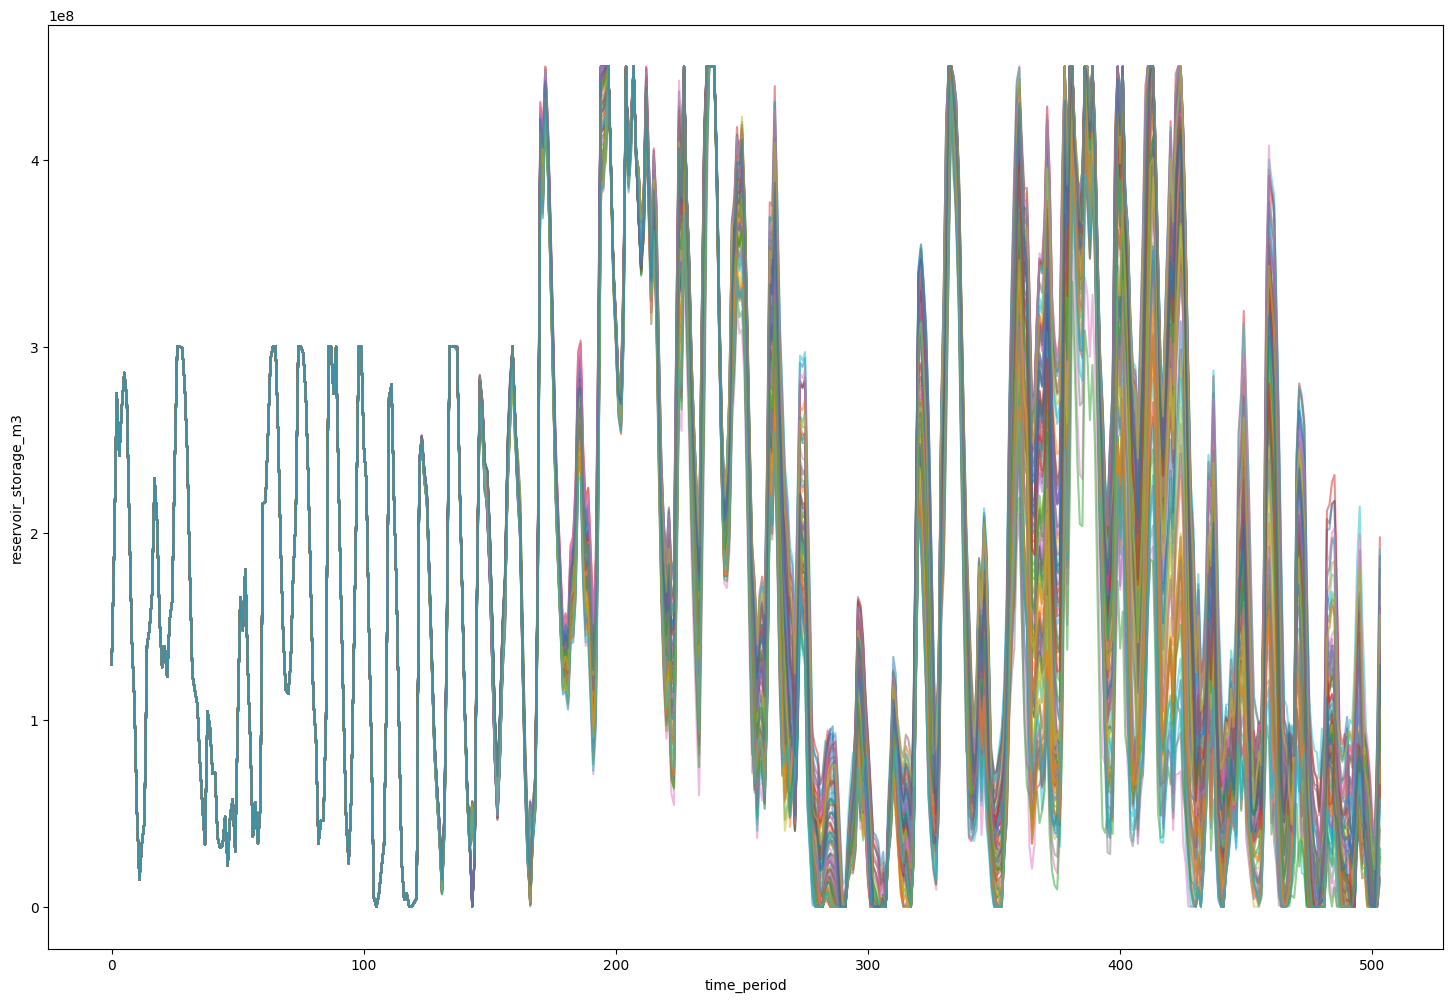

In [116]:
output_plot = "reservoir_storage_m3"

all_strategies = sorted(list(df_attribute_strategy[sa.field_key_strategy].unique()))

strategy_plot = 6
fig, ax = plt.subplots(figsize = (18, 12))

for strat in [strategy_plot]:
    
    primaries = get_primary_keys_from_strat(strat)
    if len(primaries) == 0:
        print(f"No information found for strategy {strat}")
        continue
        
    df_filt = df_output[
        df_output[sa.field_key_primary].isin(primaries)
    ]
    
    dfg = df_filt.groupby([sa.field_key_primary])
    
    for i, df in dfg:
        y = np.array(df[output_plot]) 
        x = range(len(y))

        ax.plot(
            x, 
            y, 
            alpha = 0.5,
        )

# add some properties
ax.set_xlabel(sa.field_time_period)
ax.set_ylabel(output_plot)


In [122]:
df_model_data.columns

Index(['time_period', 'year', 'month', 'flow_m3s', 'precipitation_mm',
       'population', 'demand_municipal_m3p', 'demand_agricultural_m3km2',
       'area_ag_km2', 'capacity_reservoir_million_m3',
       'increase_ag_efficiency_rate', 'increase_mun_efficiency_rate',
       'transmission_gw_ag_m3s', 'transmission_gw_mun_m3s',
       'transmission_res_ag_m3s', 'transmission_res_mun_m3s',
       'recylcing_proportion_mun', 'wastewater_treatment_capacity_m3s'],
      dtype='object')

In [120]:
list(range(5, 10))

[5, 6, 7, 8, 9]